# Working with Superphot+

Superphot+ was designed to rapidly fit photometric SN-like light curves to an empirical model for subsequent classification or analysis.
This tutorial briefly covers how to import light curves directly from ALeRCE or ANTARES, apply pre-processing for improved quality, and run various sampling methods to fit the light curves.

## Light curve import

There are a suite of helper functions in `import_ztf_from_alerce.py` to import photometric light curves from the ALeRCE or ANTARES servers. We will do both here to compare:

In [1]:
from dustmaps.config import config

config["data_dir"] = "."  # ensure dustmaps path is correct

from superphot_plus.constants import *  # all hyperparameters/priors for fitting
from superphot_plus.file_paths import *  # all default file paths, change accordingly
from superphot_plus.utils import *  # all utility functions
from superphot_plus.import_ztf_from_alerce import *

In [2]:
test_sn = "ZTF22abvdwik"  # can change to any ZTF supernova

For this tutorial, we will save everything in `../examples/outputs/`

In [3]:
OUTPUT_DIR = "../examples/outputs/"
os.makedirs(OUTPUT_DIR, exist_ok=True)
generate_single_flux_file(test_sn, OUTPUT_DIR)

../examples/outputs/ZTF22abvdwik.csv


Great! Now let's extract and plot the lightcurve:

In [4]:
import pandas as pd

lc_fn = os.path.join(OUTPUT_DIR, test_sn + ".csv")
df = pd.read_csv(lc_fn)
df

,tid,mjd,candid,fid,pid,diffmaglim,isdiffpos,nid,distnr,magpsf,...,magapbig,sigmagapbig,has_stamp,corrected,dubious,step_id_corr,phase,parent_candid,drb,rfid
0,ztf,59902.203692,2148203692115015011,2,2148203692115,20.372300,1,2148,2.014740,20.264100,...,20.1133,0.3801,False,False,False,1.1.6,0.0,2.148280e+18,NaN,NaN
1,ztf,59902.280069,2148280062115015013,1,2148280062115,20.216372,1,2148,1.879129,20.042442,...,19.6675,0.2136,True,False,False,1.1.6,0.0,NaN,0.995911,650120121.0
2,ztf,59904.178796,2150178792115015047,1,2150178792115,20.618118,1,2150,1.854762,19.739748,...,19.4887,0.1743,True,False,False,1.1.6,0.0,NaN,0.999254,650120121.0
3,ztf,59904.196331,2150196332115015044,2,2150196332115,20.588760,1,2150,1.647079,19.854446,...,19.6504,0.2347,True,False,False,1.1.6,0.0,NaN,0.998228,650120221.0
4,ztf,59906.152778,2152152772115015009,2,2152152772115,20.328976,1,2152,1.637041,19.599812,...,19.3334,0.1956,True,False,False,1.1.6,0.0,NaN,0.999996,650120221.0
5,ztf,59906.199965,2152199962115015019,1,2152199962115,20.751240,1,2152,1.570132,19.463880,...,19.3485,0.1484,True,False,False,1.1.6,0.0,NaN,0.999997,650120121.0
6,ztf,59908.238495,2154238492115015017,1,2154238492115,20.428700,1,2154,1.807830,19.313800,...,19.0642,0.1211,False,False,False,1.1.6,0.0,2.156177e+18,NaN,NaN
7,ztf,59910.177002,2156177002115015009,2,2156177002115,20.472574,1,2156,1.796709,19.132210,...,19.1670,0.1611,True,False,False,1.1.6,0.0,NaN,1.000000,650120221.0
8,ztf,59910.214583,2156214582115015024,1,2156214582115,20.686329,1,2156,1.647136,19.132908,...,18.9604,0.1033,True,False,False,1.1.6,0.0,NaN,0.999981,650120121.0
9,ztf,59913.170127,2159170122115015010,2,2159170122115,20.332615,1,2159,1.785321,19.133406,...,19.1690,0.1795,True,False,False,1.1.6,0.0,NaN,0.999999,650120221.0


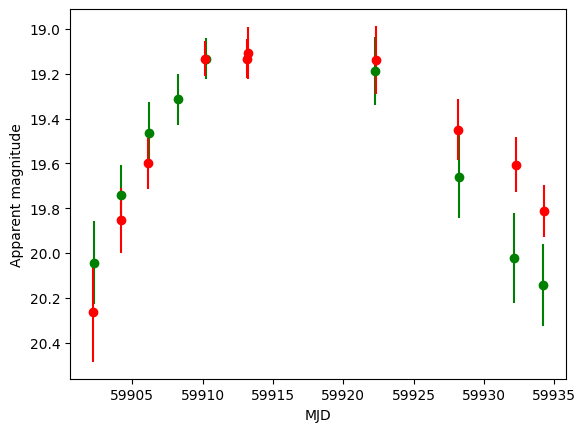

In [5]:
import matplotlib.pyplot as plt

m = df["magpsf"]  # magnitudes
merr = df["sigmapsf"]  # mag errs
t = df["mjd"]  # times
b = df["fid"] - 1  # alter so 0=g, 1=r

plt.errorbar(t[b == 0], m[b == 0], yerr=merr[b == 0], fmt="o", c="g")
plt.errorbar(t[b == 1], m[b == 1], yerr=merr[b == 1], fmt="o", c="r")

plt.xlabel("MJD")
plt.ylabel("Apparent magnitude")
plt.gca().invert_yaxis()

Because our fitting procedure assumes flux units instead of magnitude, we convert using an average zeropoint of 26.3. We also rule out any NaN values, sort the lightcurve, clip bogus LC tails, and apply extinction:

Text(0, 0.5, 'Flux (in arbitrary units)')

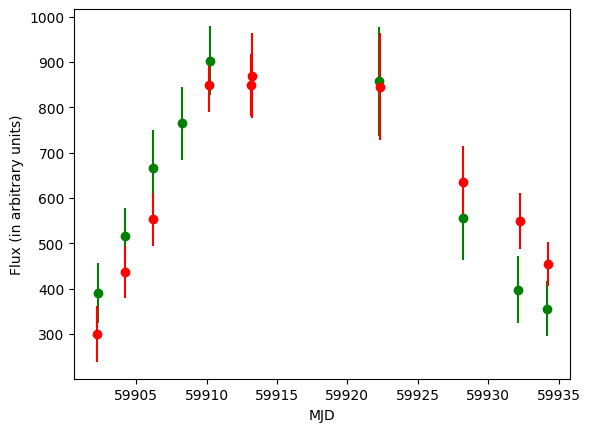

In [6]:
t, f, ferr, b, ra, dec = import_lc(lc_fn)

plt.close()
plt.errorbar(t[b == "g"], f[b == "g"], yerr=ferr[b == "g"], fmt="o", c="g")
plt.errorbar(t[b == "r"], f[b == "r"], yerr=ferr[b == "r"], fmt="o", c="r")

plt.xlabel("MJD")
plt.ylabel("Flux (in arbitrary units)")

We will then save these pre-processed lightcurves as a separate file to be input into the fitting scripts:

In [7]:
save_datafile(test_sn, t, f, ferr, b, OUTPUT_DIR)

['59902.28006940009' '390.72227369700147' '67.06838531186001' 'g']


## Fitting Light Curves

There are a few sampling techniques implemented for rapid fitting of light curves:
* Nested sampling (`dynesty`) constrains the posterior space with nested ellipsoids of increasing density.
* Advanced HMC with the NUTS sampler (using `numpyro`) uses Hamiltonian Monte Carlo sampling but without U-turns to increase sampling efficiency.
* Stochastic variational inference (SVI; also using `numpyro`) approximates the marginal distributions for each fit as Gaussians, which sacrifices precision for much faster runtime. Recommended for realtime applications.

Let's use each to fit our test light curve:

In [8]:
from superphot_plus.ztf_transient_fit import *
from superphot_plus.fit_numpyro import *

/n/home06/kdesoto/personal_envs/superphot_flowMC_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO[2023-07-26 16:30:57,249]: Unable to initialize backend 'cuda': FAILED_PRECONDITION: No visible GPU devices.
INFO[2023-07-26 16:30:57,255]: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter CUDA
INFO[2023-07-26 16:30:57,257]: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
WARNING[2023-07-26 16:30:57,260]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [9]:
fn_to_fit = os.path.join(OUTPUT_DIR, test_sn + ".npz")
import time

# let's time each fitting method
start_time = time.time()
#dynesty_single_file(fn_to_fit, OUTPUT_DIR, skip_if_exists=False)  # nested sampling
dynesty_total_time = time.time() - start_time
print("Nested sampling", dynesty_total_time)

Nested sampling 6.175041198730469e-05


In [10]:
start_time = time.time()
#numpyro_single_file(fn_to_fit, OUTPUT_DIR, sampler="NUTS")  # nested sampling
nuts_total_time = time.time() - start_time
print("NUTS", nuts_total_time)

NUTS 0.00010752677917480469


In [11]:
start_time = time.time()
#numpyro_single_file(fn_to_fit, OUTPUT_DIR, sampler="svi")  # nested sampling
svi_total_time = time.time() - start_time
print("SVI", svi_total_time)

SVI 7.343292236328125e-05


Now, let's plot each fit to compare results!

Loading light curve from ../examples/outputs/ZTF22abvdwik.npz
Loading light curve from ../examples/outputs/ZTF22abvdwik.npz
Loading light curve from ../examples/outputs/ZTF22abvdwik.npz


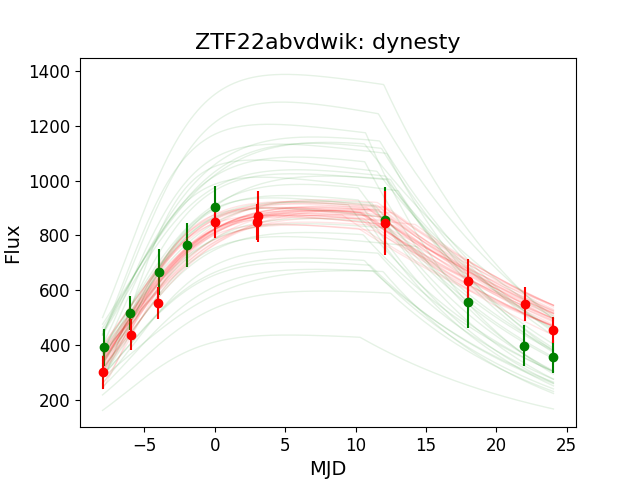

In [12]:
from superphot_plus.plotting import plot_lc_fit
from IPython import display

for method in ["dynesty", "NUTS", "svi"]:
    plot_lc_fit(test_sn, OUTPUT_DIR, OUTPUT_DIR, OUTPUT_DIR, method)

display.Image(os.path.join(OUTPUT_DIR, test_sn + "_dynesty.png"))

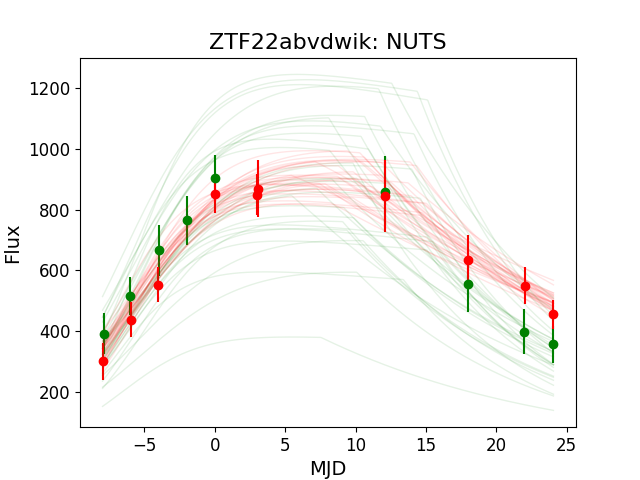

In [13]:
display.Image(os.path.join(OUTPUT_DIR, test_sn + "_NUTS.png"))

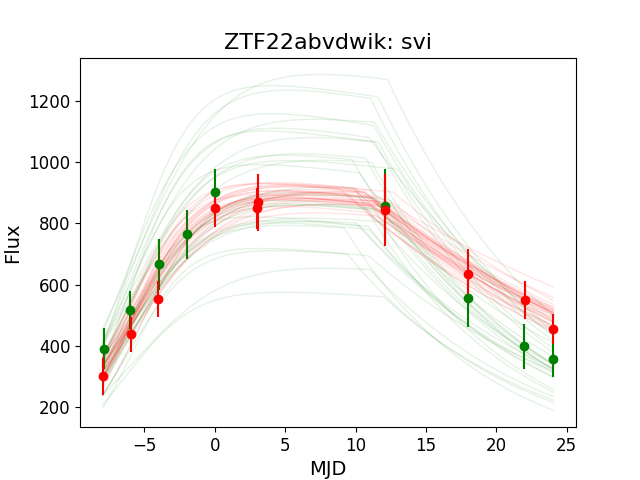

In [14]:
display.Image(os.path.join(OUTPUT_DIR, test_sn + "_svi.png"))

It looks like there is a tradeoff between fit time and fit quality, though there may be an issues with priors. Plotting the distribution for our differing parameters ($t0$ and $\gamma$), we get:

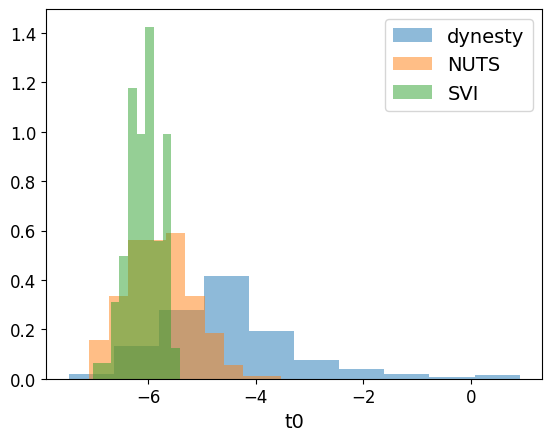

In [15]:
params_dynesty = np.load(os.path.join(OUTPUT_DIR, test_sn + "_eqwt_dynesty.npz"))["arr_0"]
params_NUTS = np.load(os.path.join(OUTPUT_DIR, test_sn + "_eqwt_NUTS.npz"))["arr_0"]
params_svi = np.load(os.path.join(OUTPUT_DIR, test_sn + "_eqwt_svi.npz"))["arr_0"]

t0_idx = 3
gamma_idx = 2

plt.hist(params_dynesty[:, t0_idx], alpha=0.5, label="dynesty", density=True)
plt.hist(params_NUTS[:, t0_idx], alpha=0.5, label="NUTS", density=True)
plt.hist(params_svi[:, t0_idx], alpha=0.5, label="SVI", density=True)
plt.xlabel("t0")
plt.legend()
plt.show()

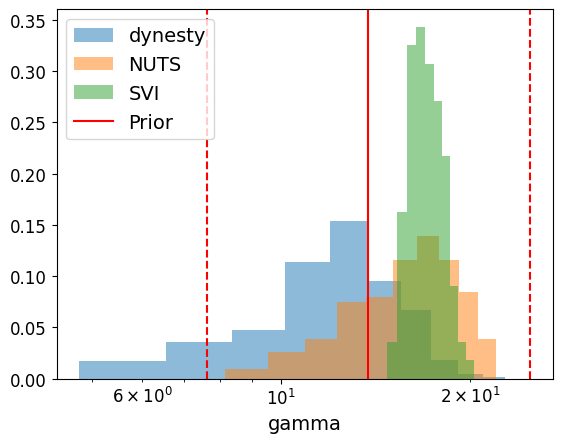

In [16]:
plt.hist(params_dynesty[:, gamma_idx], alpha=0.5, label="dynesty", density=True)
plt.hist(params_NUTS[:, gamma_idx], alpha=0.5, label="NUTS", density=True)
plt.hist(params_svi[:, gamma_idx], alpha=0.5, label="SVI", density=True)
plt.axvline(10 ** PRIOR_GAMMA[2], c="r", label="Prior")
plt.axvline(10 ** (PRIOR_GAMMA[2] + PRIOR_GAMMA[3]), c="r", linestyle="dashed")
plt.axvline(10 ** (PRIOR_GAMMA[2] - PRIOR_GAMMA[3]), c="r", linestyle="dashed")
plt.xlabel("gamma")
plt.legend()
plt.xscale("log")
plt.show()

## Classification

Superphot+ uses the resulting fit parameters as input features for a multi-layer perceptron (MLP) classifier. We can call the classification functions to return probabilities of the object being each of 5 major supernova types:

In [17]:
from superphot_plus.classify_ztf import classify_single_light_curve, classify_from_fit_params
from superphot_plus.classify_ztf import load_mlp, adjust_log_dists
from superphot_plus.file_utils import get_posterior_samples

model = load_mlp(TRAINED_MODEL_FN, TRAINED_MODEL_PARAMS)
lc_probs = classify_single_light_curve(model, test_sn, OUTPUT_DIR)
print(lc_probs)

# Alternatively, classify from posterior samples directly
fit_params = get_posterior_samples(test_sn, OUTPUT_DIR, "dynesty")
print(np.mean(fit_params, axis=0))
adj_params = adjust_log_dists(fit_params)
lc_probs2 = classify_from_fit_params(model, adj_params)
print(np.subtract(lc_probs, np.mean(lc_probs2, axis=0)))

[0.69842273 0.0741306  0.05805596 0.05576415 0.11362673]
[ 1.05595076e+03  5.09312774e-03  1.25759931e+01 -4.52628750e+00
  4.13026952e+00  2.32305917e+01  2.41854733e-02  1.15711693e+00
  1.04229983e+00  1.01088171e+00  9.99981644e-01  9.65310259e-01
  5.82045280e-01  8.59578902e-01 -5.42938501e+00]
[0. 0. 0. 0. 0.]


## Improvements that need to be made:

* Exploration why variation between dynesty + numpyro fits
* Quantifying minimum number of iters for SVI or warmup samples for NUTS for asymptotic fitting behavior
* Modularizing numpyro script, removal of magic numbers
* Refining plotting file, maybe splitting into separate folder